In [3]:
!pip install mne
!pip install pycwt


   ---------------------------------------- 0.0/753.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/753.5 kB ? eta -:--:--
   ------------- -------------------------- 262.1/753.5 kB ? eta -:--:--
   ---------------------------------------- 753.5/753.5 kB 1.4 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import mne
from pywt import cwt
import matplotlib.pyplot as plt

# Verify file path and load data
file_path = 'Original_Data.xlsx'
try:
    raw_data = pd.ExcelFile(file_path)
except FileNotFoundError:
    print(f"Error: File {file_path} not found in working directory")
    print("Verify file path or upload the dataset")


Creating RawArray with float64 data, n_channels=30, n_times=76001
    Range : 0 ... 76000 =      0.000 ...   148.438 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=76001
    Range : 0 ... 76000 =      0.000 ...   148.438 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 845 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 845 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


ECBL total alpha spindles: 9
EOBL total alpha spindles: 0
Difference (ECBL - EOBL): 9

Electrode-wise comparison:
     ECBL  EOBL  Difference
CP1     1   NaN         NaN
CP2     1   NaN         NaN
FT9     1   NaN         NaN
Fp2     1   NaN         NaN
Fz      1   NaN         NaN
P3      1   NaN         NaN
P4      1   NaN         NaN
Pz      2   NaN         NaN


C:\Users\Siwar\AppData\Local\Temp\ipykernel_14864\3297699221.py:144: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  eobl_counts = pd.Series([s[2] for s in eobl_spindles]).value_counts().sort_index()


Writing C:\Users\Siwar\Lab Assignment - EEG Spindle\ecbl_raw.fif
Closing C:\Users\Siwar\Lab Assignment - EEG Spindle\ecbl_raw.fif
[done]
Writing C:\Users\Siwar\Lab Assignment - EEG Spindle\eobl_raw.fif
Closing C:\Users\Siwar\Lab Assignment - EEG Spindle\eobl_raw.fif
[done]


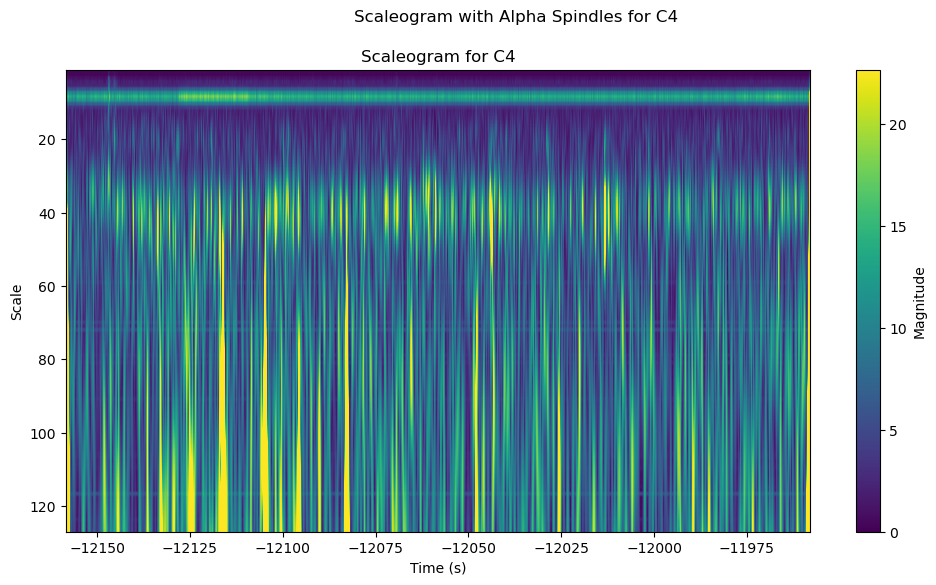

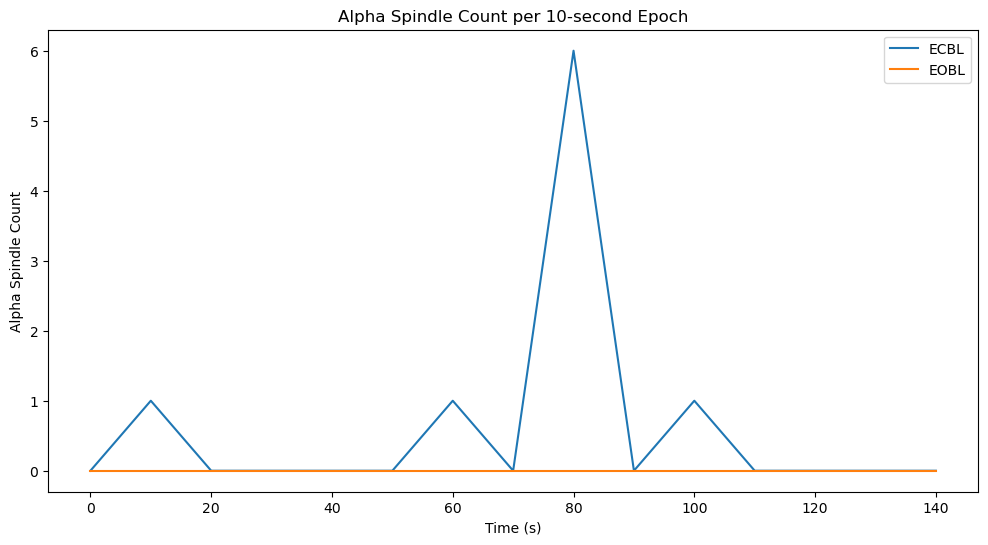

In [11]:
import numpy as np
import pandas as pd
import mne
import pywt
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.signal import hilbert  # Updated import

# Load the data
def load_data(file_path):
    # Read the Excel file with both sheets
    ecbl_df = pd.read_excel(file_path, sheet_name='ECBL')
    eobl_df = pd.read_excel(file_path, sheet_name='EOBL')
    
    # Assuming the first column is time and the rest are EEG channels
    ecbl_data = ecbl_df.iloc[:, 1:].values.T  # Channels x Time
    eobl_data = eobl_df.iloc[:, 1:].values.T
    times = ecbl_df.iloc[:, 0].values
    
    # Create MNE Info object
    sfreq = 512  # Sampling frequency
    ch_names = list(ecbl_df.columns[1:])  # Channel names
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    
    # Create MNE Raw objects
    ecbl_raw = mne.io.RawArray(ecbl_data, info)
    eobl_raw = mne.io.RawArray(eobl_data, info)
    
    return ecbl_raw, eobl_raw, times

# Function to detect alpha spindles
def detect_alpha_spindles(raw, sfreq=512, alpha_band=(8, 13), threshold=2.0, min_duration=0.5):
    """
    Detect alpha spindles in EEG data.
    
    Parameters:
    - raw: MNE Raw object
    - sfreq: Sampling frequency
    - alpha_band: Frequency range for alpha (8-13 Hz)
    - threshold: Number of standard deviations for detection
    - min_duration: Minimum duration in seconds for a spindle
    
    Returns:
    - spindle_events: List of spindle events (start, end, channel)
    """
    # Band-pass filter in alpha range
    raw_filtered = raw.copy().filter(alpha_band[0], alpha_band[1])
    
    spindle_events = []
    
    for i, ch in enumerate(raw.ch_names):
        data = raw_filtered.get_data(picks=ch)[0]
        
        # Calculate envelope using Hilbert transform (updated)
        analytic_signal = hilbert(data)
        amplitude_envelope = np.abs(analytic_signal)
        
        # Threshold detection
        mean = np.mean(amplitude_envelope)
        std = np.std(amplitude_envelope)
        threshold_value = mean + threshold * std
        
        # Find where envelope exceeds threshold
        above_threshold = amplitude_envelope > threshold_value
        changes = np.diff(above_threshold.astype(int))
        starts = np.where(changes == 1)[0]
        ends = np.where(changes == -1)[0]
        
        # Handle edge cases
        if len(ends) == 0:
            continue
        if len(starts) == 0:
            continue
        if starts[0] > ends[0]:
            starts = np.insert(starts, 0, 0)
        if ends[-1] < starts[-1]:
            ends = np.append(ends, len(data)-1)
        
        # Check duration and add to spindles
        for s, e in zip(starts, ends):
            duration = (e - s) / sfreq
            if duration >= min_duration:
                spindle_events.append((s/sfreq, e/sfreq, ch))
    
    return spindle_events

# Function to compute and plot scaleogram
def plot_scaleogram(data, times, ch_name, sfreq=512, scales=np.arange(1, 128)):
    """
    Compute and plot wavelet scaleogram for a single channel.
    """
    # Compute Continuous Wavelet Transform
    coefficients, frequencies = pywt.cwt(data, scales, 'morl', sampling_period=1.0/sfreq)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(np.abs(coefficients), extent=[times[0], times[-1], scales[-1], scales[0]],
                   cmap='viridis', aspect='auto', norm=Normalize(vmin=0, vmax=np.percentile(np.abs(coefficients), 95)))
    
    ax.set_title(f'Scaleogram for {ch_name}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Scale')
    fig.colorbar(im, ax=ax, label='Magnitude')
    
    return fig, coefficients

# Function for epoch-based analysis
def epoch_based_analysis(raw, spindle_events, epoch_length=10, sfreq=512):
    """
    Divide data into epochs and count spindles in each epoch.
    """
    total_duration = raw.n_times / sfreq
    n_epochs = int(np.ceil(total_duration / epoch_length))
    
    epoch_counts = []
    
    for i in range(n_epochs):
        start_time = i * epoch_length
        end_time = (i + 1) * epoch_length
        
        # Count spindles in this epoch
        epoch_spindles = [s for s in spindle_events if start_time <= s[0] < end_time]
        epoch_counts.append(len(epoch_spindles))
        
    return epoch_counts

# Main analysis function
def analyze_eeg_data(file_path):
    # 1. Load data
    ecbl_raw, eobl_raw, times = load_data(file_path)
    
    # 2. Detect alpha spindles (Problem 1 & 2)
    ecbl_spindles = detect_alpha_spindles(ecbl_raw)
    eobl_spindles = detect_alpha_spindles(eobl_raw)
    
    # Problem 1: Total count comparison
    print(f"ECBL total alpha spindles: {len(ecbl_spindles)}")
    print(f"EOBL total alpha spindles: {len(eobl_spindles)}")
    print(f"Difference (ECBL - EOBL): {len(ecbl_spindles) - len(eobl_spindles)}")
    
    # Problem 2: Electrode-wise comparison
    ecbl_counts = pd.Series([s[2] for s in ecbl_spindles]).value_counts().sort_index()
    eobl_counts = pd.Series([s[2] for s in eobl_spindles]).value_counts().sort_index()
    comparison_df = pd.DataFrame({'ECBL': ecbl_counts, 'EOBL': eobl_counts})
    comparison_df['Difference'] = comparison_df['ECBL'] - comparison_df['EOBL']
    print("\nElectrode-wise comparison:")
    print(comparison_df)
    
    # Problem 3: Scaleogram visualization
    # Select a channel for visualization (e.g., first channel)
    ch_name = ecbl_raw.ch_names[0]
    data = ecbl_raw.get_data(picks=ch_name)[0]
    
    # Plot scaleogram
    fig_scaleogram, coefficients = plot_scaleogram(data, times, ch_name)
    
    # Mark spindles on the scaleogram
    ax = fig_scaleogram.axes[0]
    for spindle in [s for s in ecbl_spindles if s[2] == ch_name]:
        ax.axvspan(spindle[0], spindle[1], alpha=0.3, color='red')
    fig_scaleogram.suptitle(f'Scaleogram with Alpha Spindles for {ch_name}')
    
    # Problem 4: Epoch-based analysis
    epoch_counts_ecbl = epoch_based_analysis(ecbl_raw, ecbl_spindles)
    epoch_counts_eobl = epoch_based_analysis(eobl_raw, eobl_spindles)
    
    # Plot epoch counts
    fig_epoch, ax = plt.subplots(figsize=(12, 6))
    ax.plot(np.arange(len(epoch_counts_ecbl)) * 10, epoch_counts_ecbl, label='ECBL')
    ax.plot(np.arange(len(epoch_counts_eobl)) * 10, epoch_counts_eobl, label='EOBL')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Alpha Spindle Count')
    ax.set_title('Alpha Spindle Count per 10-second Epoch')
    ax.legend()
    
    # Save figures
    fig_scaleogram.savefig('scaleogram_with_spindles.png')
    fig_epoch.savefig('epoch_spindle_counts.png')
    
    # Save data in FIF and CSV formats
    ecbl_raw.save('ecbl_raw.fif', overwrite=True)
    eobl_raw.save('eobl_raw.fif', overwrite=True)
    comparison_df.to_csv('electrode_comparison.csv')
    
    return {
        'total_counts': {'ECBL': len(ecbl_spindles), 'EOBL': len(eobl_spindles)},
        'electrode_comparison': comparison_df,
        'epoch_counts': {'ECBL': epoch_counts_ecbl, 'EOBL': epoch_counts_eobl}
    }

# Run the analysis
if __name__ == "__main__":
    file_path = "Original_Data.xlsx"
    results = analyze_eeg_data(file_path)